# Bin height gradient accuracy -- bandwidth vs. number of samples 

In [29]:
import jax
import jax.numpy as jnp
from jax.random import normal, PRNGKey

from matplotlib.colors import to_rgb
import matplotlib.pyplot as plt

plt.rc('figure', figsize=[7.3,4], dpi=226, facecolor='w')

from functools import partial

Kde-based histogram:

In [6]:
import jax.scipy as jsc


def kde_hist(events, bins, bandwidth, density = False):
    
    edge_hi = bins[1:]  # ending bin edges ||<-
    edge_lo = bins[:-1]  # starting bin edges ->||

    # get cumulative counts (area under kde) for each set of bin edges
    cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1, 1), loc=events, scale=bandwidth)
    cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1, 1), loc=events, scale=bandwidth)
    # sum kde contributions in each bin
    counts = (cdf_up - cdf_dn).sum(axis=1)

    if density:  # normalize by bin width and counts for total area = 1
        db = jnp.array(jnp.diff(bins), float)  # bin spacing
        return counts / db / counts.sum(axis=0)

    return counts

Since we know analytically that the height of a bin defined by $(a,b)$ for a given $\mu$ value is just

$$\operatorname{freq}_{\mathsf{true}}(\mu; a,b) = \operatorname{normcdf}(b;\mu) - \operatorname{normcdf}(a;\mu) $$

we can then just diff this wrt $\mu$ by hand:

$$\operatorname{normcdf}(x;\mu) = \frac{1}{2}\left[1+\operatorname{erf}\left(\frac{x-\mu}{\sigma \sqrt{2}}\right)\right]$$

$$\Rightarrow \frac{\partial}{\partial\mu}\operatorname{normcdf}(x;\mu) = \frac{1}{2}\left[1-\left(\frac{2}{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}\right)\right]$$

since $\frac{d}{d z} \operatorname{erf}(z)=\frac{2}{\sqrt{\pi}} e^{-z^{2}}$. 

We have $\sigma=1$, making this simpler:

$$\Rightarrow \frac{\partial}{\partial\mu}\operatorname{normcdf}(x;\mu) = \frac{1}{2}\left[1-\left(\frac{2}{\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2}}\right)\right]$$

All together:


$$\Rightarrow \frac{\partial}{\partial\mu}\operatorname{freq}_{\mathsf{true}}(\mu; a,b) = -\frac{1}{\sqrt{2\pi}}\left[\left(e^{-\frac{(b-\mu)^2}{2}}\right) - \left( e^{-\frac{(a-\mu)^2}{2}}\right)\right]$$

In code:


In [7]:
def true_grad(mu,bins):
    
    b = bins[1:]  # ending bin edges ||<-
    a = bins[:-1]  # starting bin edges ->||
    
    return -(1/((2*jnp.pi)**0.5))*(jnp.exp(-((b-mu)**2)/2) - jnp.exp(-((a-mu)**2)/2))

In [44]:
# generate a set of normal samples centered on `mu`
def gen_points(mu, jrng, nsamples):
    points = normal(jrng, shape = (nsamples,))+mu
    return points

# fn to return the height of the 3rd bin made by kde_hist
def bin_height(mu, jrng, bw, nsamples, bins):
    points = gen_points(mu, jrng, nsamples)
    return kde_hist(points, bins, bandwidth=bw)[2]


# workflow to get the relative absolute error between true & kde gradients
# given a bandwidth `bw` and a number of samples to draw `nsamples`
def kde_grads_mse(bw, nsamples, nrngs = 9, lo = -2, hi = +2, grid_size = 500):
    
    bins = jnp.linspace(lo-3,hi+3,6)
    
    mu_grid = jnp.linspace(lo,hi,grid_size)
    
    rngs = [PRNGKey(i) for i in range(nrngs)]
    
    grad_fun = jax.grad(bin_height)
    
    grads = []

    for i,jrng in enumerate(rngs):
        get_grads = jax.vmap(partial(
            grad_fun, jrng=jrng, bw=bw, nsamples=nsamples, bins=bins
        ))
        grads.append(get_grads(mu_grid))
    
    true_grad_many = jax.vmap(partial(true_grad, bins = bins))
    true = true_grad_many(mu_grid)[:,2] * nsamples
    
    grads = jnp.asarray(grads)
    
    pull = (true - grads) #/ grads.std(axis=0)
    
    return pull#.mean(axis=0)

Define grid and calculate errors:

In [45]:
bws = jnp.array([0.05, 0.5, 0.8])#jnp.linspace(0.05,0.5,2)
samps = [50, 250, 5000]#jnp.linspace(10,5000,2).astype('int')

funcs = [jax.vmap(partial(kde_grads_mse, nsamples=n)) for n in samps]

pulls = jnp.array([f(bws) for f in funcs])

In [46]:
pulls.shape # samp_grid, bw_grid, rngs, mu_grid

(3, 3, 500)

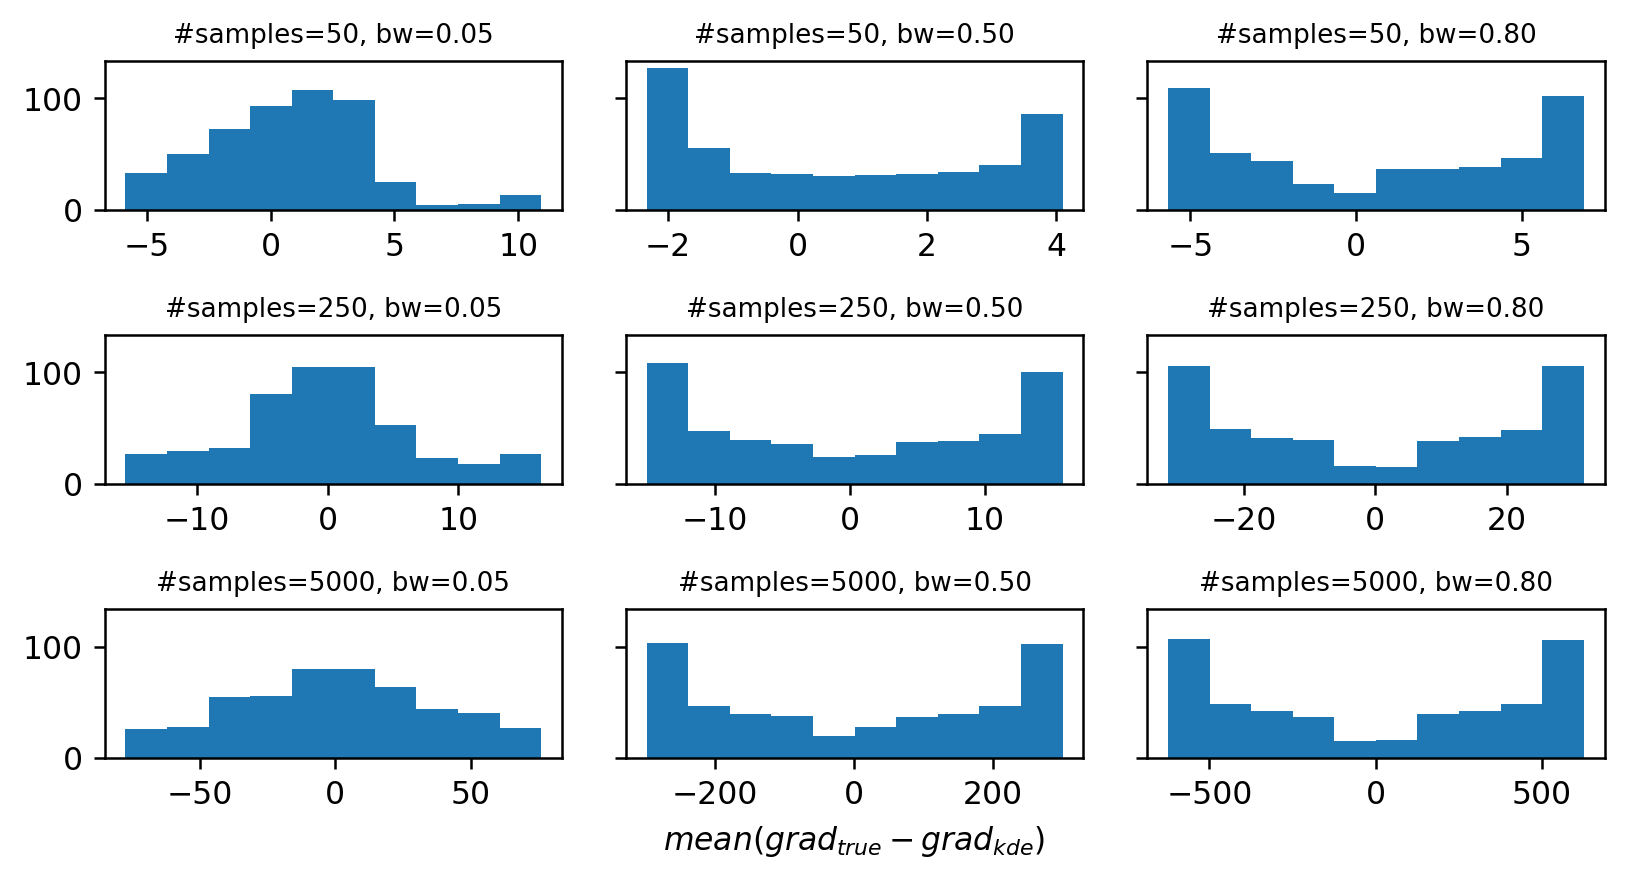

In [55]:
mus = jnp.linspace(-2,2,500)

fig, axes = plt.subplots(3,3,sharey=True)

for i,samp_row in enumerate(pulls):
    ax = axes[i]
    for j, bw_pull in enumerate(samp_row):
        ax[j].hist(bw_pull)
        ax[j].set_title(f'#samples={samps[i]}, bw={bws[j]:.2f}',size='small')
# axes[1][0].set_ylabel(r'$mean(grad_{true} - grad_{kde})$', 
#                       rotation=0,labelpad=65.3)
axes[2][1].set_xlabel(r'$mean(grad_{true} - grad_{kde})$')
plt.tight_layout()

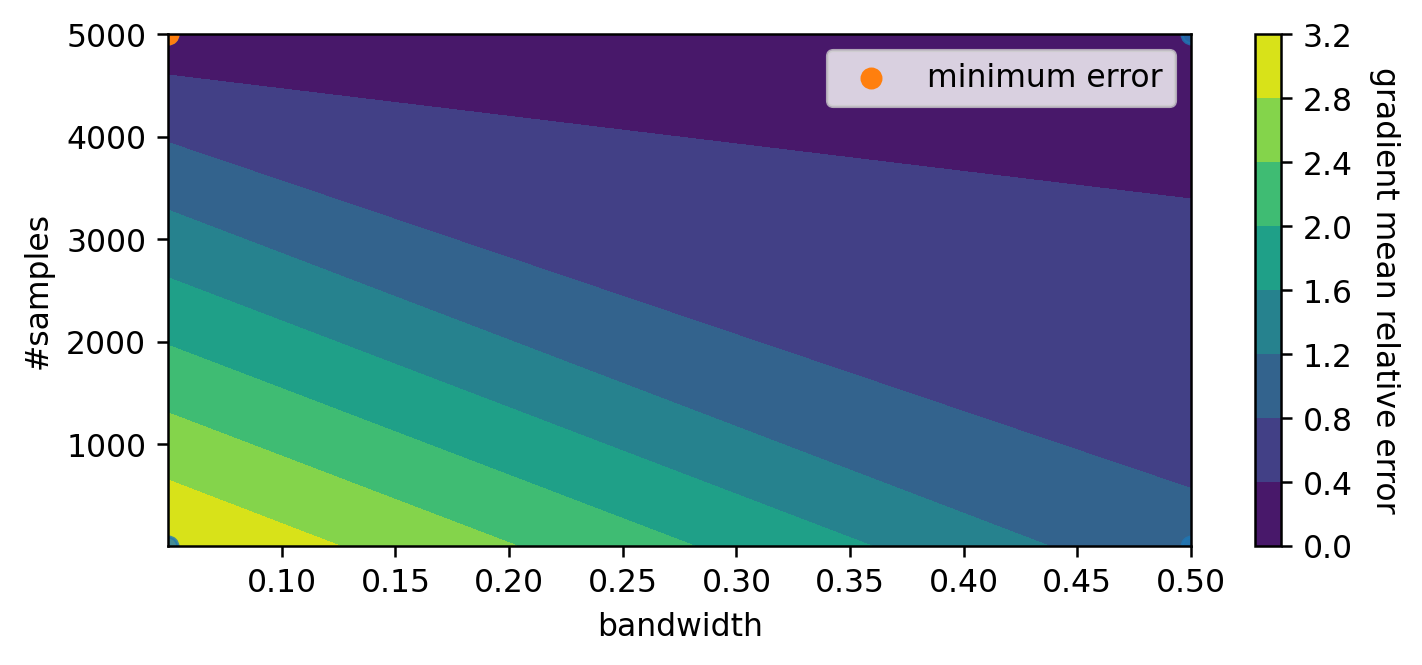

In [13]:
X, Y = jnp.meshgrid(bws,samps)

p = plt.contourf(X, Y, raes)
c = plt.colorbar(p)
c.set_label('gradient mean relative error',rotation=270, labelpad=15)
mindex = jnp.argmin(raes.ravel())

plt.scatter(X.ravel(), Y.ravel(), alpha=0.8)
plt.scatter(X.ravel()[mindex], Y.ravel()[mindex], label = 'minimum error', color='C1')

plt.xlabel('bandwidth')
plt.ylabel('#samples')
plt.legend()

plt.savefig('grads_error_plot.png',bbox_inches='tight');